# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import math  
import time 
from numpy import linalg   
import random  

In [2]:
random.seed(42) 

In [3]:
def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

In [4]:
L = 1000 
mu = 1 
d = 100 
n = 10  

A = [] 
b = []
for i in range(n): 
    A.append(generate_matrix(d, mu, L))  
    b.append(np.random.normal(d))

In [50]:
def RandK(percent, vector, d):  
    k = int(percent * d)
    indices = random.sample(range(0, d, 1), k) 
    new_vector = np.zeros(d) 
    for i in indices: 
        new_vector[i] = vector[i]  
    return (1/percent) * new_vector

In [51]:
def TopK(percent, vector, d): 
    k = int(percent * d) 
    indices = np.argpartition(np.absolute(vector), -k)[-k:] 
    new_vector = np.zeros(d) 
    for i in indices: 
        new_vector[i] = vector[i] 
    return new_vector

In [75]:
a = np.array(range(d))  
for i in range(1, len(a), 2): 
    a[i] = -a[i]
print(a)
print(TopK(0.1, a, d))

[  0  -1   2  -3   4  -5   6  -7   8  -9  10 -11  12 -13  14 -15  16 -17
  18 -19  20 -21  22 -23  24 -25  26 -27  28 -29  30 -31  32 -33  34 -35
  36 -37  38 -39  40 -41  42 -43  44 -45  46 -47  48 -49  50 -51  52 -53
  54 -55  56 -57  58 -59  60 -61  62 -63  64 -65  66 -67  68 -69  70 -71
  72 -73  74 -75  76 -77  78 -79  80 -81  82 -83  84 -85  86 -87  88 -89
  90 -91  92 -93  94 -95  96 -97  98 -99]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  90. -91.  92. -93.  94. -95.  96. -97.
  98. -99.]


In [52]:
def Compression(name, percent, vector, d): 
    if(name=='RandK'): 
        return RandK(percent, vector, d) 
    elif(name=='TopK'): 
        return TopK(percent, vector, d)

In [53]:
def grad(A, b, x, d):  
    g = np.zeros(d) 
    g = 1/2 * np.dot((A + A.T), x) - b
    return g  

In [57]:
class GradientDescent: 
    def __init__(self, A, b, max_info, lr, workers, name, percents, d): 
        self.A = A 
        self.b = b 
        self.max_info = max_info  
        self.lr = lr 
        self.x = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d)
        for i in range(0, self.max_info, self.k * self.workers):  
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)
            for j in range(self.workers): 
                h = grad(A[j], b[j], self.x, self.d) 
                full_g = full_g + h 
                g = g + Compression(self.name, self.percents, h, self.d)  
            g *= 1/self.workers 
            full_g *= 1/self.workers 
            self.x = self.x - self.lr * g
            self.grad_history.append(np.linalg.norm(full_g)**2)
            self.information_send.append(i + self.workers * self.k) 

In [58]:
gd_rand_1 = GradientDescent(A, b, 10**5, 1/L, n, 'RandK', 0.01, d)  
gd_rand_5 = GradientDescent(A, b, 10**5, 1/L, n, 'RandK', 0.05, d) 
gd_rand_10 = GradientDescent(A, b, 10**5, 1/L, n, 'RandK', 0.1, d) 
gd_rand_20 = GradientDescent(A, b, 10**5, 1/L, n, 'RandK', 0.2, d)

In [59]:
gd_rand_1.fit() 
gd_rand_5.fit() 
gd_rand_10.fit() 
gd_rand_20.fit() 

In [66]:
print(L)

1000


In [82]:
gd_top_10 = GradientDescent(A, b, 10**6, 1/(2 * L), n, 'TopK', 0.2, d)
gd_top_10.fit() 

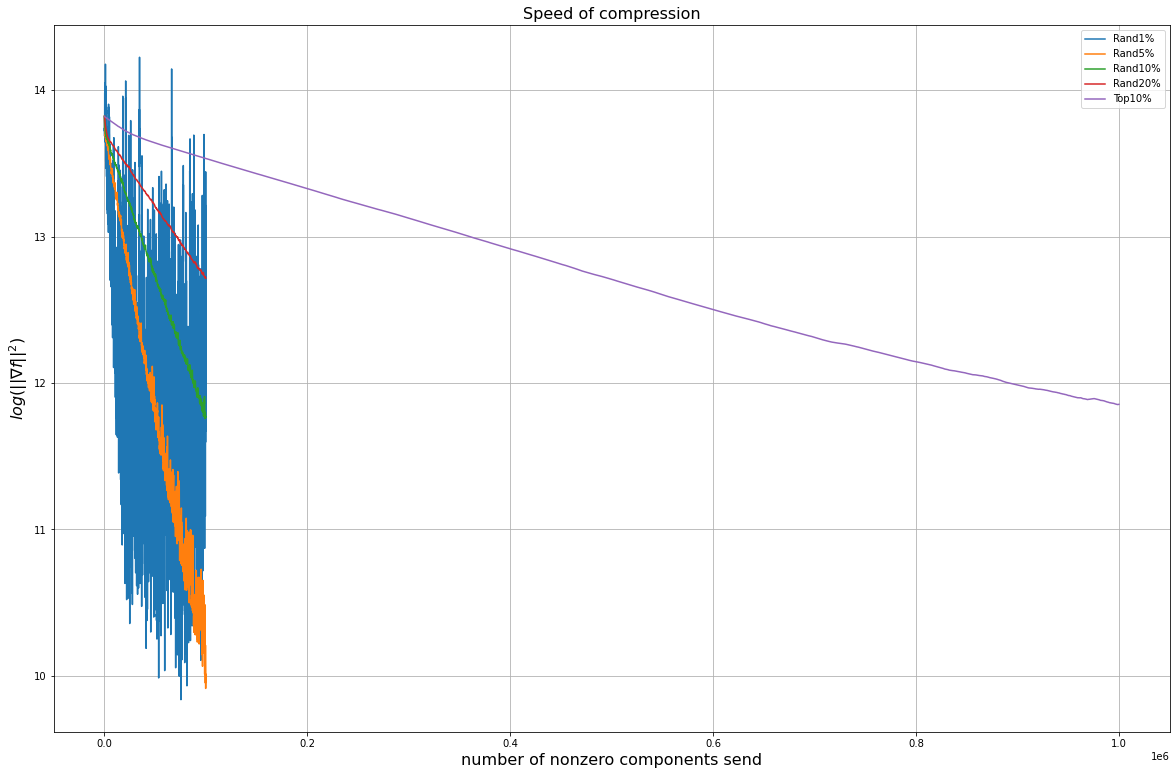

In [83]:
plt.figure(figsize=(20, 13))  
plt.title('Speed of compression', fontsize=16)  
plt.plot(gd_rand_1.information_send, np.log(gd_rand_1.grad_history), label='Rand1%') 
plt.plot(gd_rand_5.information_send, np.log(gd_rand_5.grad_history), label='Rand5%') 
plt.plot(gd_rand_10.information_send, np.log(gd_rand_10.grad_history), label='Rand10%') 
plt.plot(gd_rand_20.information_send, np.log(gd_rand_20.grad_history), label='Rand20%')  
plt.plot(gd_top_10.information_send, np.log(gd_top_10.grad_history), label='Top10%')
plt.xlabel('number of nonzero components send', fontsize=16) 
plt.ylabel(r"$log(||\nabla f||^{2})$", fontsize=16)
plt.grid() 
plt.legend() 
plt.show()

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [31]:
class GradientDescent: 
    def __init__(self, A, b, max_iter, lr, workers, name, percents, d): 
        self.A = A 
        self.b = b 
        self.max_iter = max_iter  
        self.lr = lr 
        self.x = None 
        self.iteration = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d)
        for i in range(self.max_iter):  
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)
            for j in range(self.workers): 
                h = grad(A[j], b[j], self.x, self.d) 
                full_g = full_g + h 
                g = g + Compression(self.name, self.percents, h, self.d)  
            g *= 1/self.workers 
            full_g *= 1/self.workers 
            self.x = self.x - self.lr * g
            self.grad_history.append(np.linalg.norm(full_g)**2)
            self.iteration.append(i + 1) 

In [41]:
class EFGradientDescent: 
    def __init__(self, A, b, max_iter, lr, workers, name, percents, d): 
        self.A = A 
        self.b = b 
        self.max_iter = max_iter  
        self.lr = lr 
        self.x = None 
        self.iteration = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d) 
        e_help = [] 
        for i in range(self.workers): 
            e_help.append(np.zeros(self.d))  
        
        for i in range(self.max_iter): 
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)
            for j in range(self.workers): 
                h = grad(A[j], b[j], self.x, self.d) 
                full_g = full_g + h 
                grad_update = e_help[j] + self.lr * h  
                grad_update_compression = Compression(self.name, self.percents, h, self.d)
                g = g + grad_update_compression
                e_help[j] = grad_update - grad_update_compression  
            g *= 1/self.workers 
            full_g *= 1/self.workers
            self.x = self.x - g  
            self.grad_history.append(np.linalg.norm(full_g)**2)
            self.iteration.append(i+1)  

In [42]:
gd_top_10 = GradientDescent(A, b, 10**4, 1/5 * 1/L, n, 'TopK', 0.1, d) 
efgd_top_10 = EFGradientDescent(A, b, 10**4, 1/1000 * 1/L, n, 'TopK', 0.1, d) 

In [43]:
gd_top_10.fit() 
efgd_top_10.fit()

/tmp/ipykernel_858194/675168206.py:31: RuntimeWarning: invalid value encountered in subtract
  e_help[j] = grad_update - grad_update_compression
/tmp/ipykernel_858194/675168206.py:27: RuntimeWarning: invalid value encountered in add
  full_g = full_g + h
/tmp/ipykernel_858194/675168206.py:27: RuntimeWarning: overflow encountered in add
  full_g = full_g + h
/tmp/ipykernel_858194/675168206.py:30: RuntimeWarning: invalid value encountered in add
  g = g + grad_update_compression


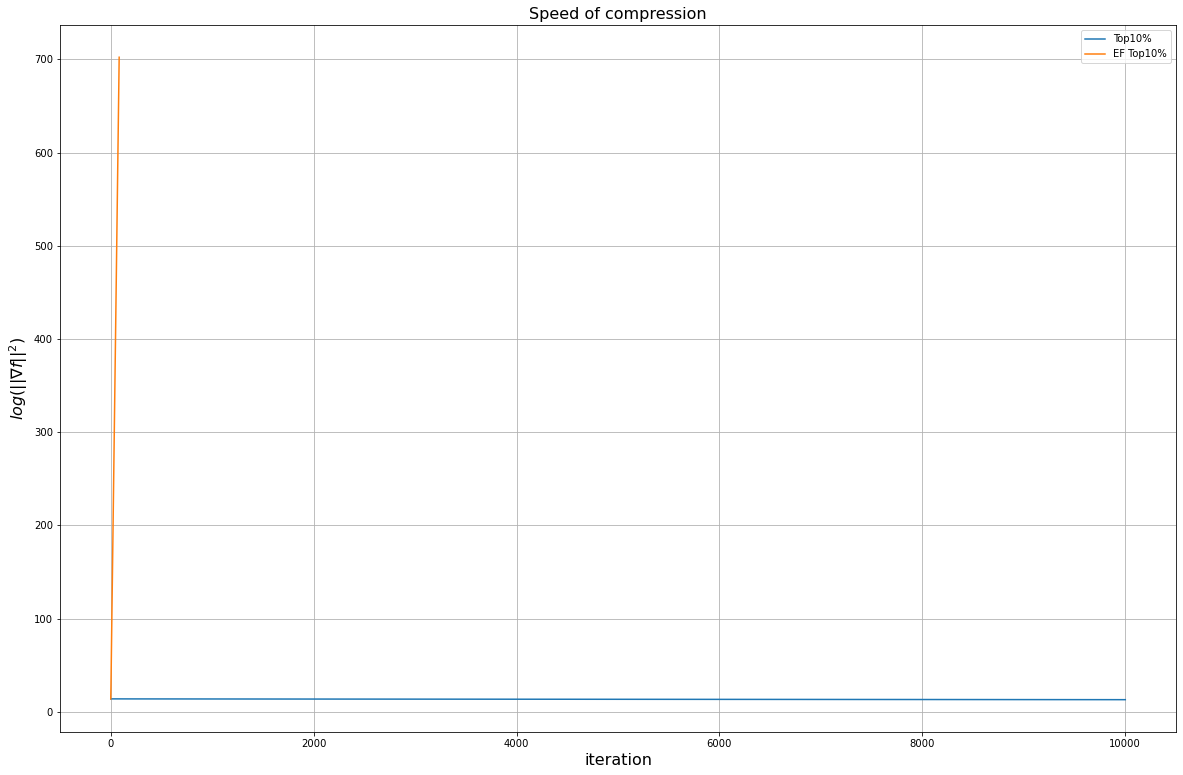

In [44]:
plt.figure(figsize=(20, 13))  
plt.title('Speed of compression', fontsize=16)  
plt.plot(gd_top_10.iteration, np.log(gd_top_10.grad_history), label='Top10%') 
plt.plot(efgd_top_10.iteration, np.log(efgd_top_10.grad_history), label='EF Top10%') 
plt.xlabel('iteration', fontsize=16) 
plt.ylabel(r"$log(||\nabla f||^{2})$", fontsize=16)
plt.grid() 
plt.legend() 
plt.show()

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [1]:
#ответ

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [2]:
#ответ

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [ ]:
#ответ

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [ ]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#ответ